# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №1 - Метод k-средних, предобработка признаков


# <hr\>
**Общая информация**

**Срок сдачи:** до 7 октября 2017, 06:00   
**Штраф за опоздание:** -2 балла после 06:00 7 октября, -4 балла после 06:00 14 октября, -6 баллов после 06:00 21 октября

При отправлении ДЗ указывайте фамилию в названии файла   


Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush
Необходимо в slack создать таск в приватный чат:   
/todo Фамилия Имя *ссылка на гитхаб* @alkhamush   
Пример:   
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush   

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

# Первое задание - указать фамилию в имени файла

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Пролог: Модуль sklearn
На наших практических занятиях мы будем использовать [sklearn](http://scikit-learn.org/stable/index.html) (scikit-learn) - наиболее популярный модуль для работы с методами машинного обучения и анализа данных.

Этот модуль регулярно обновляется, расширяется и сопровождается примерами использования тех или иных методов. Помимо самих алгоритмов (например k-средних или линейной регрессии) в нем есть множество вспомогательных функций по работе с данными.

# Туториал: Работа с различными типами признаков

Вспомним какие типы признаков могут встретится при описании объектов исследования и как их представить в доступной для обработки компьтером форме

Типы признаков мы будем рассматривать на примере довольно популярного набора данных [titanic](https://www.kaggle.com/c/titanic/download/train.csv) - информации о выживаемости пассажиров после известной трагедии корабля Titanic.

In [3]:
df_titanic = pd.read_csv('train.csv', sep=',').dropna()
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


## Бинарные признаки
Это признаки с двумя возможными значениями
* Пол (мужской, женский)
* Выжил (да, нет)

На вход в алгоритмы обычно подаются в виде значений `{0, 1}` (реже в виде `{-1, 1}`)

In [4]:
# Здесь все нормально
df_titanic.Survived.value_counts()

1    123
0     60
Name: Survived, dtype: int64

In [5]:
# Тут стоит выполнить переобознаение
df_titanic.Sex.value_counts()

male      95
female    88
Name: Sex, dtype: int64

In [6]:
# Например так
df_titanic.Sex = df_titanic.Sex.replace({'male': 0, 'female': 1})
df_titanic.Sex.value_counts()

0    95
1    88
Name: Sex, dtype: int64

## Вещественные признаки

* Возраст
* Сумма, потраченная на билет
* Количество родственников на борту

Как правило остаются в том же виде или выполняется **нормализация** признаков, т.е. переход к одинаковой шкале, например:

* $\tilde{x} = \frac{x - \text{mean}(x)}{\text{std}(x)}$
* $\tilde{x} = \frac{x - \text{min}(x)}{\text{max}(x) - \text{min}(x)}$

## Категориальные признаки

Принимают значения из *неупорядоченного* множества

* Порт погрузки (C = Cherbourg; Q = Queenstown; S = Southampton)
* Точка отправления (St Louis, MO; Montreal, PQ; .. }
* Точка назначения (Chesterville, ON; Roseville, IL; .. }

Обычно такие признаки кодируют с помощью так называемого One Hot Encoding: </br>
для каждой категории создается бинарная маска-столбец, в которой стоит `1` если значение признака равно значению соответствующей категории категории.

Например, для признака "порт погрзки" создается бинарная макска из трех стобцов для каждого из портов: С, Q, S<br/>
Если пассажир заходил на кораблю в порту Southampton, то его признаковое описание будет соответственно: `[0, 0, 1]`

In [7]:
df_titanic.Embarked.head()

1     C
3     S
6     S
10    S
11    S
Name: Embarked, dtype: object

In [8]:
# Сделать в python это можно несколькими способами:

# 1: Через pandas (не очень рекомендуется)
emb = pd.get_dummies(df_titanic.Embarked, prefix='Embarked', prefix_sep='=')
emb.head()

,Embarked=C,Embarked=Q,Embarked=S
1,1,0,0
3,0,0,1
6,0,0,1
10,0,0,1
11,0,0,1


In [9]:
# 2: Функционал sklearn
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

emb = df_titanic.loc[:, ['Embarked']].replace({'C': 0, 'Q': 1, 'S': 2}).values
emb_enc = encoder.fit_transform(emb)
emb_enc[:5]

array([[ 1.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])

Про другием способы работы с категориальными переменными можно прочитать вот [тут](https://alexanderdyakonov.wordpress.com/2016/08/03/python-%D0%BA%D0%B0%D1%82%D0%B5%D0%B3%D0%BE%D1%80%D0%B8%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5-%D0%BF%D1%80%D0%B8%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8/)

## Порядковый признаки

Принимают значения из *упорядоченного* множества

* Класс каюты (1 > 2 > 3)

В зависимости от метода остаются можно оставить в исходном виде или применить OneHotEncoding.

## Текстовые признаки - Bag of words

Для демонстрации возьмем текст стихотворения Блока:

Ночь, улица, фонарь, аптека,<br/>
Бессмысленный и тусклый свет.<br/>
Живи еще хоть четверть века -<br/>
Все будет так. Исхода нет.<br/>

Умрешь - начнешь опять сначала<br/>
И повторится все, как встарь:<br/>
Ночь, ледяная рябь канала,<br/>
Аптека, улица, фонарь.<br/>

Пусть каждая строчка - это будет условный документ. Переведем эти документы в числовое представление по методу мешка слов (Bag Of Words)

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = \
[u'Ночь, улица, фонарь, аптека,',
 u'Бессмысленный и тусклый свет.',
 u'Живи еще хоть четверть века -',
 u'Все будет так. Исхода нет.',
 u'Умрешь - начнешь опять сначала',
 u'И повторится все, как встарь:',
 u'Ночь, ледяная рябь канала,',
 u'Аптека, улица, фонарь.']

In [11]:
vect = CountVectorizer()

bow = vect.fit_transform(corpus)
bow = bow.toarray()
bow.shape

(8, 27)

Получили матрицу размера $8 \times 27$, так как у нас 8 строчек и выделилось 27 униальных слов. Элемент матрицы показывает сколько раз слово встречалось в соответствующем документе.

In [12]:
bow

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 1, 0, 0]])

In [13]:
# Посмотрим какие слова стоят по столбцам
for i, w in enumerate(vect.get_feature_names()):
    print u'столбец %d: %s' % (i, w)

столбец 0: аптека
столбец 1: бессмысленный
столбец 2: будет
столбец 3: века
столбец 4: все
столбец 5: встарь
столбец 6: еще
столбец 7: живи
столбец 8: исхода
столбец 9: как
столбец 10: канала
столбец 11: ледяная
столбец 12: начнешь
столбец 13: нет
столбец 14: ночь
столбец 15: опять
столбец 16: повторится
столбец 17: рябь
столбец 18: свет
столбец 19: сначала
столбец 20: так
столбец 21: тусклый
столбец 22: улица
столбец 23: умрешь
столбец 24: фонарь
столбец 25: хоть
столбец 26: четверть


# Туториал: Имплементация собственного метода

Для решения задач вида "имплементируйте метод X" крайне желательно (но необязательно) реализовывать методы с помощью интерфейса sklearn. Ниже вы увидите пример очень простого **классификатора**. Используйте эти наработи для выполнения задания.

Загрузите [датасет](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) с информацией о характеристиках вина и его качестве. (В метод `pd.read_csv()` можно подать веб-ссылку на данные и пандас их скачает и преобразует в `DataFrame`).

In [14]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [15]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Наша задача состоит в предсказании целевого признака `quality` по остальным признакам. `quality` - это вещественная переменная (оценка качества от 0 до 10). Упростим себе задачу - создадим новый столбец `quality_cat` по следующим правилам:

* `quality_cat = 1` если `quality > 5` 
* `quality_cat = 0` - иначе 

Таким образом, `quality_cat` характерует "плохое" и "хорошее" вино.

In [16]:
def prepocess_wine(df):
    df.loc[:, 'quality_cat'] = (df.loc[:, 'quality'] > 5).astype(int)
    df = df.drop('quality', axis=1)
    
    return df

In [17]:
df_wine = df_wine.pipe(prepocess_wine)
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


Нарисуем распределение хорошего и плохого вина по признаку `alcohol`.

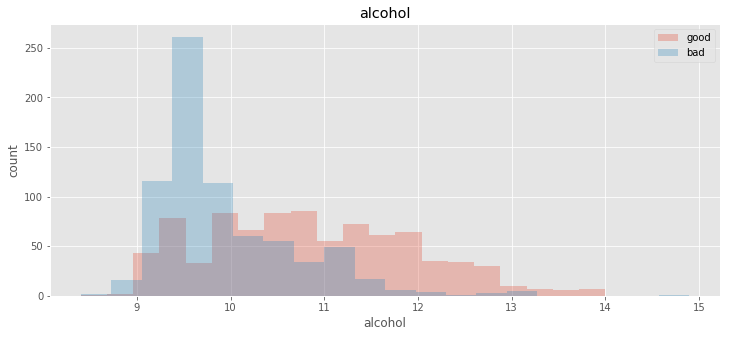

In [18]:
_, ax = plt.subplots(1,1)
df_wine.query('quality_cat == 1').hist('alcohol', alpha=0.3, bins=20, label='good', ax=ax)
df_wine.query('quality_cat == 0').hist('alcohol', alpha=0.3, bins=20, label='bad', ax=ax)
ax.set_xlabel('alcohol')
ax.set_ylabel('count')
plt.legend()

Визуально кажется, что можно найти некоторое пороговое значение признака `alcohol` $\theta$, чтобы хорошо дискриминировать между плохими и хорошим вином:
* Если `alcohol >` $\theta$ - то предсказываем, что вино хорошее
* Если `alcohol <=` $\theta$ - то предсказываем, что вино плохое

Обучаеть классификатор будем очень просто: перебирать значения признака alchol и считать **ошибку** классификации. То значение, где ошибка минимальна и будет оптимальным.

Разделим целевой признак от остальных признаков

In [19]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

Далее вы увидете пример реализации этого простого классификатора.

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin

class SimpleClassifier(BaseEstimator, ClassifierMixin): 
    
    def __init__(self):
        """
        Инициализация метода
        """
        
        self.threshold = 0

    def fit(self, X, y=None):
        """
        Выполняет процедуру обучения классификатора. В данном случае - перебор занчения признака alcohol.
        Договоримся, что признак alcohol будет в последнем столбце матрицы X
        """
        
        alcohol = X[:,-1]
        n = float(y.shape[0])
        
        # Задаем пространство поиска
        alco_range = np.arange(alcohol.min(), alcohol.max(), 0.1)
        
        min_error_rate = 1
                
        #  Начинаем поиск
        for theta in alco_range:
            prediction = alcohol > theta
            
            error_rate = sum(prediction != y)/n
            
            if error_rate < min_error_rate:
                min_error_rate = error_rate
                self.threshold = theta  
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания класса по обученному порогу
        """
        
        return (X[:,-1] > self.threshold).astype(int)

Обучаем модель

In [21]:
model = SimpleClassifier()
model.fit(X, y)

print 'Оптимальный порог: %f' % model.threshold

Оптимальный порог: 10.000000


Получаем предсказание модели (на обучающей выборке)

In [22]:
y_hat = model.predict(X)

Оценим долю ошибок на обучающей выборке

In [23]:
error_rate = sum(y_hat != y)/float(y.shape[0])
print 'Доля ошибок на обучающей выборке: %f' % error_rate

Доля ошибок на обучающей выборке: 0.295184


## Проверка метода на контрольной выборке

Мы обучили наш метод на данных о красном виде. 

Посмотрим, выполняется ли так же хорошо закономерность между качеством и уровнем алкоголя в белом вине.

In [24]:
df_wine_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
                           sep=';')

df_wine_test = df_wine_test.pipe(prepocess_wine)
df_wine_test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [25]:
X_test, y_test = df_wine_test.iloc[:, :-1].values, df_wine_test.iloc[:, -1].values
y_hat = model.predict(X_test)

In [26]:
error_rate = sum(y_hat != y_test)/float(y_test.shape[0])
print 'Доля ошибок на контрольной выборке: %f' % error_rate

Доля ошибок на контрольной выборке: 0.312577


Получилось неплохо и это лишь наивный алгоритм на одном признаке! Ну а выводы делайте сами =)

# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). Для этого рекомендуется использовать инструмент %timeit. График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [47]:
from sklearn.base import ClusterMixin, BaseEstimator

class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, k=2, metric='euclidean', max_iter=1000, eps=0.2, random_state=1234, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :eps - параметр близости обновлённых центроидов для останова
        :random_state - seed для инициализации генератора случайных чисел
        :init - стандартный kmeans(random) или kmeans++(k-means)
        """
        
        self.k = k
        self.metric = metric
        self.max_iter = max_iter
        self.eps = eps
        self.init = init
        self.random_state = random_state
        
    def _euclidean(self, a, c):
        d = np.empty(a.shape[0])
        for i in range(0, a.shape[0]):
            d[i] = np.sqrt(np.sum(np.power(np.subtract(a[i], c), 2)))
        return d
    
    def _cityblock(self, a, c):
        d = np.empty(a.shape[0])
        for i in range(0, a.shape[0]):
            d[i] = np.sum(np.absolute(np.subtract(a[i], c)))
        return d
        
    def _metric_dist(self):
        if self.metric == 'euclidean':
            return self._euclidean
        if self.metric == 'cityblock':
            return self._cityblock
        
    def _init_centers(self, X, y=None):
        if self.init == 'random':
            centroids_labels = np.random.choice(X.shape[0], self.k, replace=False)
            
            self.centroids = X[centroids_labels]
        
        if self.init == 'k-means':
            centroids = np.empty((self.k, X.shape[1]))
            centroids[0] = X[np.random.choice(X.shape[0], 1, replace=False)]
            
            dist = self._metric_dist()
            d = dist(X, centroids[0])

            for i in range(1, self.k):
                
                d1 = dist(X, centroids[i - 1])
                d = np.minimum(d1, d)
                
                d2 = np.power(d, 2)
                dx2 = np.sum(d2)
                
                p = np.divide(d2, dx2)
                centroids[i] = X[np.random.choice(X.shape[0], 1, replace=False, p=p)]

            self.centroids = centroids

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """
        
        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])
        new_labels = np.empty(X.shape[0])
        
        # Массив с центройдами кластеров
        new_centroids = np.empty((self.k, X.shape[1]))

        self._init_centers(X, y = y)
        centroids = self.centroids
        
        dist = self._metric_dist()
        
        for i in range(0, X.shape[0]):
            self.labels[i] = np.argmin(dist(centroids, X[i]))
        
        i = 0
        
        while(True):
            
            for j in range(0, self.k):
                new_centroids[j] = np.average(X[self.labels == j], axis=0)
            
            for j in range(0, X.shape[0]):
                new_labels[j] = np.argmin(dist(new_centroids, X[j]))

            centroid_shift = np.sqrt(np.sum((np.power(np.subtract(centroids, new_centroids), 2))))
            
            self.labels = new_labels
            self.centroids = new_centroids
            
            i = i + 1
            if (centroid_shift < self.eps or i >= self.max_iter):
                break
                
            centroids = new_centroids
        
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        labels = np.empty(X.shape[0])
        
        for i in range(0, X.shape[0]):
            labels[i] = np.argmin(dist(self.centroids, X[i]))
        
        return labels

class MiniBatchKMeans(Kmeans):
    def __init__(self, k=2, b=1000, metric='euclidean', 
                 max_iter=1000, eps=0.2, random_state=None, init='random'):
        self.k = k
        self.b = b
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.eps = eps
        self.init = init
        
    def fit(self, X, y=None):
        
        np.random.seed(self.random_state)
        self._init_centers(X, y=y)
        centroids = self.centroids
        
        d_labels = np.empty(self.b)
        
        dist = self._metric_dist()
        
        for i in range (0, self.max_iter):
            batch_labels = np.random.choice(X.shape[0], self.b, replace=False)
            batch = X[batch_labels]

            for j in range(0, batch.shape[0]):
                d_labels[j] = np.argmin(dist(centroids, batch[j]))
                
            d_labels = d_labels.astype(int)
            
            old_centroids = centroids
            
            v = np.zeros(self.k)
            for x in range(0, self.b):
                c = d_labels[x]
                v[c] = v[c] + 1
                n = 1 / v[c]
                centroids[c] = (1 - n)*centroids[c] + n*batch[x]
                
            centroid_shift = np.sqrt(np.sum((np.power(np.subtract(centroids, 
                                                                  old_centroids), 
                                                      2))))
            if centroid_shift < self.eps:
                break
        
        self.centroids = centroids
        self.labels = np.empty(X.shape[0])
        
        for i in range(0, X.shape[0]):
            self.labels[i] = np.argmin(dist(self.centroids, X[i]))
        
        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [28]:
from sklearn.datasets import make_blobs

In [49]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
                  center_box=(-10.0, 10.0), shuffle=False, 
                              random_state=1234)

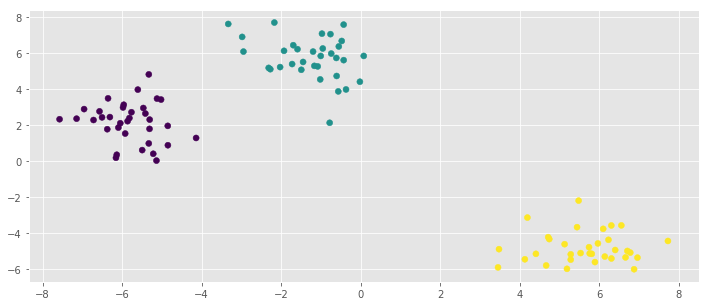

In [30]:
plt.scatter(X[:,0], X[:, 1], c=y)

Проверьте Вашу имплементацию на простых данных (без этого пункта задание не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

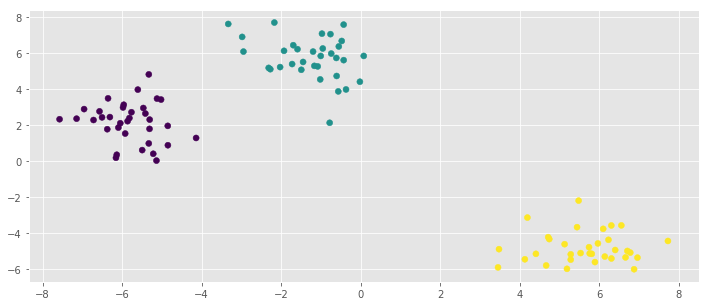

In [53]:
## Работоспособность KMeans

model = Kmeans(k = 3, random_state = 14)
labels = model.fit(X, y).labels

plt.scatter(X[:, 0], X[:, 1], c = labels)

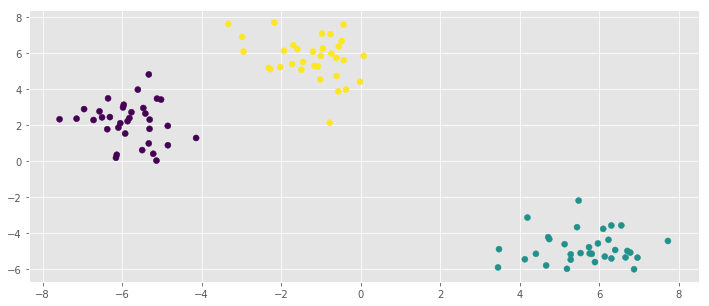

In [32]:
## Работоспособность KMeans++

model = Kmeans(k = 3, init = 'k-means', random_state = 14)
labels = model.fit(X, y).labels

plt.scatter(X[:, 0], X[:, 1], c = labels)

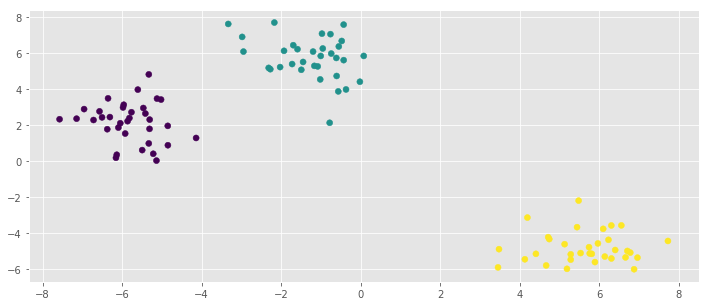

In [33]:
## Работоспособность KMeans с MiniBatchKMeans

model = MiniBatchKMeans(k=3, b=10, random_state=14)
labels = model.fit(X, y).labels

plt.scatter(X[:, 0], X[:, 1], c = labels)

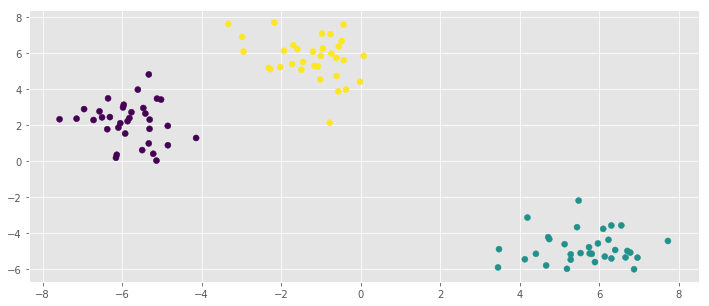

In [34]:
## Работоспособность KMeans++ с MiniBatchKMeans

model = MiniBatchKMeans(k=3, b=10, init='k-means', random_state=14)
labels = model.fit(X, y).labels

plt.scatter(X[:, 0], X[:, 1], c = labels)

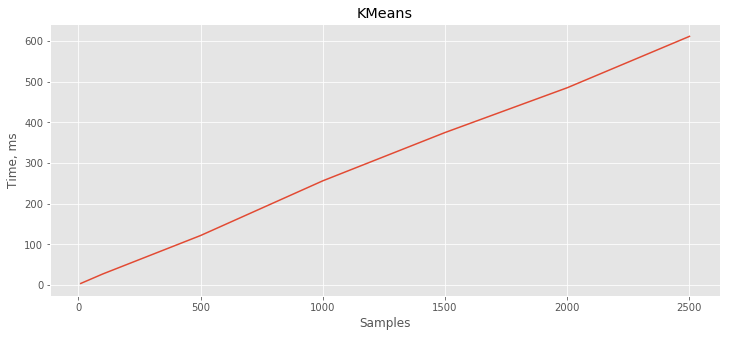

In [35]:
## Время выполнения алгоритма KMeans
model = Kmeans(k=3, random_state=14)

n = [10, 100, 500, 1000, 1500, 2000, 2500]
tm = np.empty(np.size(n))

for i in range(0, np.size(n)):
    X, y = make_blobs(n_samples=n[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    t = %timeit -o -q -n3 (model.fit(X, y))
    tm[i] = t.best * 1000.0
    
plt.xlabel('Samples')
plt.ylabel('Time, ms')
plt.title('KMeans')

plt.plot(n, tm)

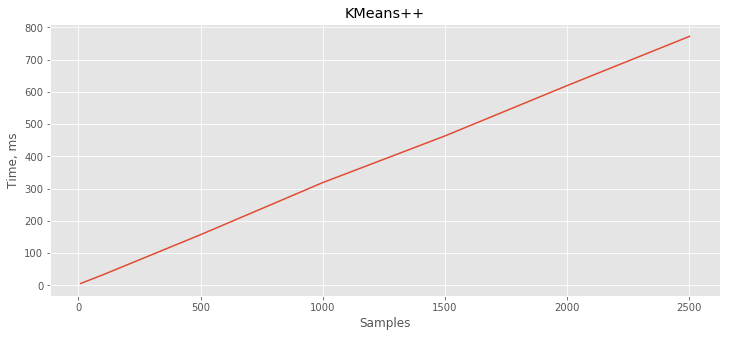

In [36]:
## Время выполнения алгоритма KMeans++
model = Kmeans(k=3, init='k-means', random_state=14)
n = [10, 100, 500, 1000, 1500, 2000, 2500]
tm = np.empty(np.size(n))

for i in range(0, np.size(n)):
    X, y = make_blobs(n_samples=n[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    t = %timeit -o -q -n3 (model.fit(X, y))
    tm[i] = t.best*1000.0
    
plt.xlabel('Samples')
plt.ylabel('Time, ms')
plt.title('KMeans++')

plt.plot(n, tm)

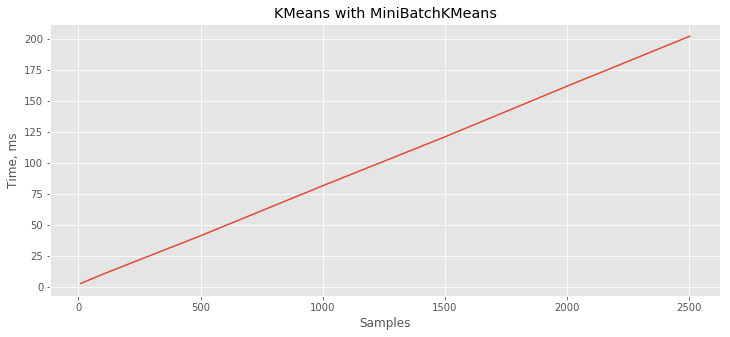

In [37]:
## Время выполнения алгоритма KMeans с MiniBatchKMeans

model = MiniBatchKMeans(k=3, b=10, random_state=99)

n = [10, 100, 500, 1000, 1500, 2000, 2500]
tm = np.empty(np.size(n))

for i in range(0, np.size(n)):
    X, y = make_blobs(n_samples=n[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    t = %timeit -o -q -n3 (model.fit(X, y))
    tm[i] = t.best*1000.0
    
plt.xlabel('Samples')
plt.ylabel('Time, ms')
plt.title('KMeans with MiniBatchKMeans')

plt.plot(n, tm)

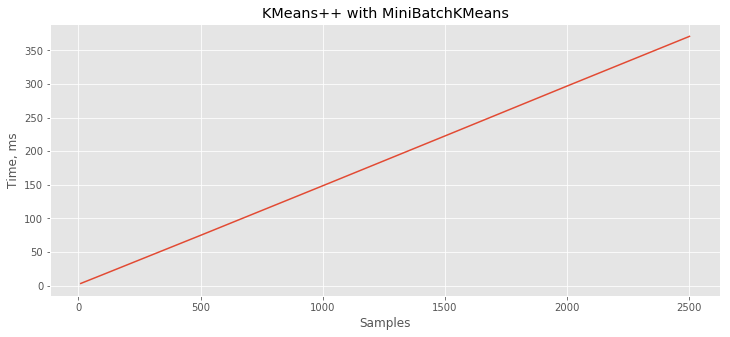

In [38]:
## Время выполнения алгоритма  KMeans++ с MiniBatchKMeans

model = MiniBatchKMeans(k=3, b=10, init='k-means', random_state=99)

n = [10, 100, 500, 1000, 1500, 2000, 2500]
tm = np.empty(np.size(n))

for i in range(0, np.size(n)):
    X, y = make_blobs(n_samples=n[i], n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    t = %timeit -o -q -n3 (model.fit(X, y))
    tm[i] = t.best*1000.0
    
plt.xlabel('Samples')
plt.ylabel('Time, ms')
plt.title('KMeans++ with MiniBatchKMeans')

plt.plot(n, tm)

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [39]:
df_sns = pd.read_csv('snsdata.csv', sep=',')
df_sns.head()

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [40]:
#extract 36 key-words features
df = df_sns.iloc[:, 4:]
X_values = df.values

In [41]:
#normalize
X = (X_values - X_values.mean(axis = 0)) / X_values.std(axis = 0)

In [42]:
def print_clusters(centroids):
    for i in range(0, 9):
        print i, ':'

        m = np.min(centroids[i])
        c = (centroids[i] - m) / ((centroids[i] - m).mean())
        ind = centroids[i] > 0.8
        if (ind.size < 2):
            ind = centroids[i] > 0.5
            if (ind.size < 2):
                ind = centroids[i] > 0.3
                if (ind.size < 2):
                    ind = centroids[i] > 0.1
                    if (ind.size < 2):
                        ind = centroids[i] > 0.05
                    else:
                        ind = centroids[i] > 0.0
        avg = df.columns[ind]
        print list(avg)
        print '\n'

In [43]:
## KMeans

model = Kmeans(k=9, random_state=99).fit(X)
centroids = model.centroids

print_clusters(centroids)

0 :
['mall']


1 :
[]


2 :
['dance', 'hair', 'shopping', 'hollister', 'abercrombie']


3 :
['cute', 'rock', 'hair']


4 :
['basketball', 'football', 'softball', 'baseball', 'tennis', 'sports']


5 :
['sexy', 'clothes']


6 :
['god', 'die']


7 :
['volleyball', 'hot', 'death']


8 :
['band', 'marching']




In [44]:
## KMeans++

model = Kmeans(k=9, init='k-means', random_state=14).fit(X)
centroids = model.centroids

print_clusters(centroids)

0 :
[]


1 :
['god', 'church', 'jesus', 'bible', 'die', 'death']


2 :
['cute', 'mall', 'shopping', 'clothes']


3 :
['shopping', 'hollister', 'abercrombie']


4 :
['sports', 'sex', 'kissed', 'music', 'rock', 'hair', 'dress', 'clothes', 'die', 'drunk', 'drugs']


5 :
['basketball', 'softball', 'volleyball', 'sports']


6 :
['tennis', 'church']


7 :
['football', 'cheerleading', 'baseball', 'cute', 'sex', 'music', 'rock', 'hair', 'clothes', 'hollister', 'die', 'drugs']


8 :
['cute', 'sexy']




In [45]:
## KMeans с MiniBatchKMeans

model = MiniBatchKMeans(k=9, b=1000, random_state=14).fit(X)
centroids = model.centroids

print_clusters(centroids)

0 :
[]


1 :
['swimming', 'hot']


2 :
['soccer', 'sports']


3 :
['sex', 'kissed', 'band', 'music', 'rock', 'church', 'hair', 'mall', 'shopping', 'drunk']


4 :
['death']


5 :
['basketball', 'football', 'sex', 'sexy', 'dance', 'music']


6 :
['volleyball', 'cute', 'shopping']


7 :
['basketball', 'football', 'sports', 'rock', 'hair', 'dress', 'mall', 'abercrombie', 'drunk', 'drugs']


8 :
['football', 'baseball', 'sports']




In [46]:
## KMeans++ с MiniBatchKMeans

model = MiniBatchKMeans(k=9, init='k-means', b=100, random_state=99).fit(X)
centroids = model.centroids

print_clusters(centroids)

0 :
['sexy', 'church', 'mall', 'clothes']


1 :
['cute', 'sex', 'sexy', 'hot', 'band', 'music', 'rock', 'hair', 'clothes', 'die', 'death']


2 :
['basketball', 'football', 'sports', 'cute', 'sex', 'dance', 'music', 'church', 'hair', 'clothes', 'abercrombie']


3 :
['volleyball', 'swimming']


4 :
[]


5 :
['sports', 'god', 'dress']


6 :
['swimming', 'cheerleading', 'cute', 'sexy', 'hot', 'hair', 'hollister']


7 :
['cheerleading', 'cute', 'kissed', 'dance', 'music', 'church', 'jesus', 'dress', 'mall', 'shopping', 'clothes']


8 :
['baseball', 'jesus', 'mall']




## Вывод
В результате работы алгоритма kmeans++ наблюдаются более осмысленные тематические кластеры. <br>
При отображении содержимого кластеров выбираются наиболее представленные в нём элементы (иначе некоторые кластеры содержат практически все атрибуты). <br>
Наиболее ярко выражены группы, объединяемые главными словами "спорт", "религия"/"церковь"/"бог", "музыка"/"концерты"/"тусовки", "покупки", "внешний вид". Эти кластеры отображают направленность интересов школьников-подростков. Т.к. некоторые признаки можно отнести к разным кластерам (одни и те же черты и интересы могут принадлежать людям разных кругов), популярные признаки появляются в разных классах. Для этих данных алгоритмы работают примерно одинаково - школьники интересуются всеми представленными темами и не всегда имеют какое-то предподчение, поэтому признаки имеют более-менее одинаковое распределение для большинства.